<a href="https://colab.research.google.com/github/gm965/Machine-learning/blob/master/vending/ML_approach_for_consumption_estimation_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INSTALLATION PRE-REQUISITE**

In [1]:
!pip install pycaret

     |████████████████████████████████| 266kB 23.3MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 256kB 41.7MB/s 
     |████████████████████████████████| 112kB 50.2MB/s 
     |████████████████████████████████| 174kB 47.2MB/s 
     |████████████████████████████████| 1.4MB 49.9MB/s 
     |████████████████████████████████| 6.8MB 41.3MB/s 
     |████████████████████████████████| 276kB 49.1MB/s 
     |████████████████████████████████| 1.7MB 40.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0MB 33.1MB/s 
     |████████████████████████████████| 14.2MB 180kB/s 
     |████████████████████████████████| 1.2MB 38.4MB/s 
     |████████████████████████████████| 645kB 43.4MB/s 
     |████████████████████████████████| 10.1MB 20.0

#**MACHINE LEARNING APPROACH FOR CONSUMPTION ESTIMATION**

In [1]:
import pandas as pd

import os
import io
import math
import warnings
warnings.filterwarnings('ignore')

#Library for importing files in local drive in colab notebook
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

#from pycaret.regression import *

In [2]:
#Import Monthly vending kWh and Actual kWh reading data
uploaded = files.upload()

Saving Consolidated_data_for_ML.xlsx to Consolidated_data_for_ML (1).xlsx


In [4]:
df = pd.read_excel(io.BytesIO( uploaded['Consolidated_data_for_ML.xlsx']))

In [11]:
# Creating a funtion to summarize dataframe information

def data_summary(df):
    '''Summary dataframe information'''

    df_modf = pd.DataFrame({'type': df.dtypes,
                       'null_count': df.isna().sum(),
                       'null_count (%)': (df.isna().sum() / df.shape[0]) * 100,
                       'unique': df.nunique()})
    
    # Checking the null values using heatmap
    # There is any null values are occupyed here
    plt.figure(figsize=(15,5))
    sns.heatmap(df.isna(),yticklabels=False,cbar=False,cmap='viridis')
    plt.show()
    return df_modf

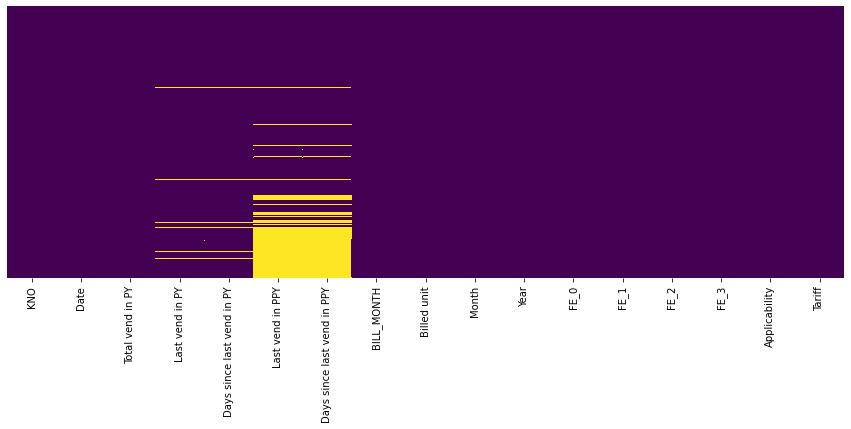

,type,null_count,null_count (%),unique
KNO,int64,0,0.000000,247
Date,datetime64[ns],0,0.000000,33
Total vend in PY,float64,1,0.012268,1297
Last vend in PY,float64,179,2.196050,434
Days since last vend in PY,float64,179,2.196050,800
Last vend in PPY,float64,2029,24.892651,386
Days since last vend in PPY,float64,2029,24.892651,601
BILL_MONTH,datetime64[ns],0,0.000000,33
Billed unit,int64,0,0.000000,1550
Month,int64,0,0.000000,12


In [12]:
data_summary(df)

In [19]:
#In the month of April, May, june the meters were not read (so their actual consumption is not known), thereby these months data has been dropped from the analysis
final_df = df[df["Applicability"]==1][["Month","Year","FE_0","FE_1","FE_2","FE_3","Total vend in PY","Last vend in PY","Days since last vend in PY","Last vend in PPY","Days since last vend in PPY","Tariff","Billed unit"]]


In [20]:
#Check if any consumer's Tariff information is missing or zero
np.where(final_df['Tariff']==0)

(array([], dtype=int64),)

In [21]:
#Encoding "Tariff" field and converting it into numeric field for analysis
tariff_dummies = pd.get_dummies(final_df.Tariff, prefix='Tariff', drop_first=True)
final_df = pd.concat([final_df, tariff_dummies], axis=1)
final_df.drop(["Tariff"], axis = 1, inplace=True) #Dropping the original "Tariff" feature after OHE encoding
final_df = final_df[["Month","Year","FE_0","FE_1","FE_2","FE_3","Total vend in PY","Last vend in PY","Days since last vend in PY","Last vend in PPY","Days since last vend in PPY","Tariff_MLLT","Tariff_NDLS","Billed unit"]]


In [24]:
#Sample data
final_df.head()

,Month,Year,FE_0,FE_1,FE_2,FE_3,Total vend in PY,Last vend in PY,Days since last vend in PY,Last vend in PPY,Days since last vend in PPY,Tariff_MLLT,Tariff_NDLS,Billed unit
0,4,2021,39844.964,40647.499,33233.121,36538.711,5000.0,5000.0,117.0,5000.0,446.0,0,0,43
1,4,2021,39844.964,40647.499,33233.121,36538.711,15000.0,10000.0,100.0,20000.0,870.0,0,1,168
2,4,2021,39844.964,40647.499,33233.121,36538.711,30000.0,10000.0,108.0,10000.0,408.0,0,1,293
3,4,2021,39844.964,40647.499,33233.121,36538.711,10000.0,5000.0,245.0,6000.0,479.0,0,1,85
4,4,2021,39844.964,40647.499,33233.121,36538.711,79830.0,20000.0,32.0,10000.0,436.0,0,1,915


In [31]:
#Only select critical features
final_df_imp = final_df[["Month","Year","FE_0","FE_3","Total vend in PY","Last vend in PY","Days since last vend in PY","Last vend in PPY","Days since last vend in PPY","Billed unit"]]


**Generate training and testing dataset for training the model and testing the model performance**

In [25]:
#Function to prepare training and testing dataset
def prepare_train_test_data(df, test_data_month = 2):
  #Get the maximum year and maximum month for which data available
  max_year = df["Year"].max()
  max_month = df[df["Year"]==max_year]["Month"].max()
  if max_month > test_data_month:

    #Training data preparation
    #Data till Dec of previous year
    train_data_till_previous_year = df[df["Year"]<max_year]
    #Data for this year till last to last month (e.g. if data is available till april, then this will give data till 28th Feb)
    train_data_current_year_till_prev2prev_month = df[(df["Year"]==max_year) & (df["Month"]<max_month-1)]
    #Total training data
    train_data = pd.concat([train_data_current_year_till_prev2prev_month,train_data_till_previous_year],axis = 0, ignore_index = True)

    #Test data preparation (Last two month data will be used for testing purpose - Mar and april 2021)
    test_data = df[(df["Year"]==max_year) & (df["Month"]>=max_month-1)]
  
  elif max_month == test_data_month:
    #Training data preparation
    #Data till Dec of previous year
    train_data = df[df["Year"]<max_year]
    
    #Test data preparation (Jan and Feb)
    test_data = df[df["Year"]==max_year]
  
  else:
    #Training data preparation
    #Data till Nov of previous year
    train_data = df[(df["Year"]<max_year) & (df["Month"]<12)]
    
    #Test data preparation (Last two month data will be used for testing purpose - Jan of current year and Dec of previous year)
    test_data_current_year = df[df["Year"]==max_year]
    test_data_prev_year = df[(df["Year"]<max_year) & (df["Month"]==12)]
    #Total testing data
    test_data = pd.concat([test_data_current_year,test_data_prev_year],axis = 0, ignore_index = True)

  return train_data, test_data

In [34]:
#Generating training and test dataset for model training and model evaluation
train_data_f_imp, test_data_f_imp = prepare_train_test_data(final_df_imp,test_data_month=2)
#Discarding the Year field
train_data_f_imp = train_data_f_imp[["Month","FE_0","FE_3","Total vend in PY","Last vend in PY","Days since last vend in PY","Last vend in PPY","Days since last vend in PPY","Billed unit"]]
test_data_f_imp = test_data_f_imp[["Month","FE_0","FE_3","Total vend in PY","Last vend in PY","Days since last vend in PY","Last vend in PPY","Days since last vend in PPY","Billed unit"]]

train_data_f_imp.shape, test_data_f_imp.shape

((6743, 9), (494, 9))

In [37]:
#Generating month wise testing dataset for further analysis
#Finding unique months data available in test data
print("Unique months for which test data is available: ", test_data_f_imp["Month"].unique())

#Separating test data frame as per different months
test_data_f_imp_3 = test_data_f_imp[test_data_f_imp["Month"]==3]
test_data_f_imp_4 = test_data_f_imp[test_data_f_imp["Month"]==4]

print("The shape of March test data: ", test_data_f_imp_3.shape)
print("The shape of April test data: ", test_data_f_imp_4.shape)

Unique months for which test data is available:  [4 3]
The shape of March test data:  (247, 9)
The shape of April test data:  (247, 9)


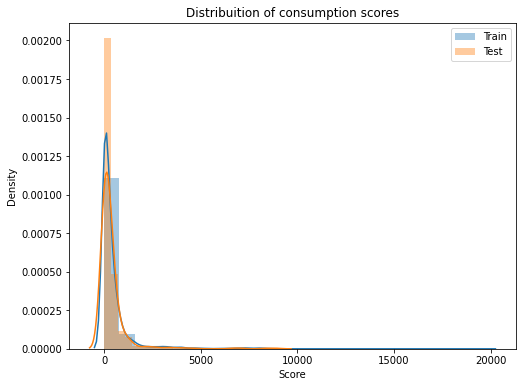

In [38]:
# Checking the distribution of the target variable both in training and testing dataset:
plt.figure(figsize=(8,6))
sns.distplot(train_data_f_imp["Billed unit"], bins=25, label = "Train")
sns.distplot(test_data_f_imp["Billed unit"], bins=25, label = "Test")
plt.xlabel('Score')
plt.legend()
plt.title('Distribuition of consumption scores');

In [29]:
print(f'Train Kurtosis: {train_data_f["Billed unit"].kurt()}')
print(f'Train Asymmetry (Skewness): {train_data_f["Billed unit"].skew()}')
print(f'Test Kurtosis: {test_data_f["Billed unit"].kurt()}')
print(f'Test Asymmetry (Skewness): {test_data_f["Billed unit"].skew()}')


Train Kurtosis: 49.11990007358662
Train Asymmetry (Skewness): 5.731886082494525
Test Kurtosis: 47.256827431616436
Test Asymmetry (Skewness): 6.181187178413992


**Kurtosis** is used to identify outliers in the distribution. If the **kurtosis** is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails)

If **skewness** is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer. In above case, it is highly skewed towards right.

###**MODEL DEVELOPMENT**

In [39]:
#Library for model development
from pycaret.regression import *

In [40]:
# Creating a pipeline to setup the model
pipeline = setup(data=train_data_f_imp, target='Billed unit', 
                 remove_multicollinearity=True,
                 normalize_method='minmax',
                 multicollinearity_threshold=0.95, 
                 normalize=True, #polynomial_features = True, polynomial_degree = 2,
                 #ignore_features = ['Month'],
                 session_id=1991
                 )

,Description,Value
0,session_id,1991
1,Target,Billed unit
2,Original Data,"(6743, 9)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4720, 19)"


####**MODEL BASELINE**

In [41]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,167.0647,181848.3408,386.3238,0.8160,2.0062,1.5443,0.138
br,Bayesian Ridge,181.9562,176938.2000,383.0475,0.8155,2.1848,2.3518,0.017
lr,Linear Regression,181.7330,176945.4805,383.0460,0.8155,2.1805,2.3160,0.273
lar,Least Angle Regression,183.6347,177426.1529,383.7498,0.8151,2.1992,2.4159,0.018
lasso,Lasso Regression,180.8865,177680.4812,384.0172,0.8147,2.1474,2.1246,0.016
ridge,Ridge Regression,184.0412,178031.9656,384.7596,0.8147,2.2026,2.4759,0.014
huber,Huber Regressor,175.9298,178312.0738,384.7625,0.8141,2.0767,1.7207,0.104
par,Passive Aggressive Regressor,176.5013,181948.0090,389.9336,0.8106,2.0353,1.5339,0.094
omp,Orthogonal Matching Pursuit,181.4628,181385.7759,389.6510,0.8099,1.9892,1.5095,0.014
llar,Lasso Least Angle Regression,185.3949,185679.5834,395.1652,0.8062,2.0965,1.8788,0.015


As seen above, the model that best fits the data is "Light Gradient Boosting Machine". So there is a need to further explore this model and fine tune it.

In [44]:
#Creating Light Gradient Boosting model with different learning rates
lr = np.arange(0.1,1,0.1)
R2 = []

for i in lr:
  lgbm = create_model('lightgbm', fold=10, round=2, learning_rate = i, verbose=False)
  R2.append(pull()["R2"]["Mean"])

R2_df = pd.DataFrame(R2, index = lr, columns = ["R2"])
R2_df

,R2
0.1,0.82
0.2,0.81
0.3,0.79
0.4,0.78
0.5,0.77
0.6,0.77
0.7,0.76
0.8,0.75
0.9,0.71


As shown above, with learning_rate = 0.1, the model performs better and fits best to training dataset. So we can create a light gradient boosting model with the same learning rate.

In [45]:
base_model = create_model('lightgbm', fold=10, round=2, learning_rate=0.1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,168.07,106613.81,326.52,0.80,2.13,3.99
1,153.73,123996.98,352.13,0.80,2.04,1.14
2,171.01,122851.03,350.50,0.84,1.82,2.02
3,215.99,850404.25,922.17,0.39,2.01,1.16
4,148.04,105668.99,325.07,0.90,2.16,1.21
5,186.06,113900.17,337.49,0.93,2.11,1.29
6,163.32,109010.22,330.17,0.87,2.00,1.22
7,156.32,98019.02,313.08,0.90,1.68,1.11
8,163.94,122228.90,349.61,0.90,2.18,1.09
9,144.18,65790.03,256.50,0.84,1.95,1.21


In [46]:
#Auto tuning the model
base_model = tune_model(base_model, fold=10, n_iter = 50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,176.3070,112584.0242,335.5354,0.7869,2.1524,3.7847
1,166.1001,138420.5819,372.0492,0.7811,2.0754,1.3127
2,168.5017,111400.1202,333.7666,0.8516,1.8372,2.4047
3,216.0684,828672.0818,910.3143,0.4019,2.0288,1.5948
4,158.4044,104503.2136,323.2696,0.9029,2.1738,1.2459
5,188.7796,107044.0448,327.1759,0.9341,2.1453,1.4706
6,168.0787,114448.9318,338.3030,0.8602,2.0340,1.3474
7,168.1777,96284.2598,310.2971,0.8977,1.7653,1.2960
8,173.1142,138399.8195,372.0213,0.8847,2.1914,1.2047
9,156.8451,70393.9353,265.3186,0.8311,2.0087,1.4729


In [47]:
# Checking score after cross-validation:
prediction = predict_model(base_model, verbose = 0)
#Saving the prediction result in a dataframe
holdout_score = pull()
display(holdout_score)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,167.5872,98585.2841,313.9829,0.9035,2.0616,1.6734


####**MODEL PERFORMANCE GRAPHS**

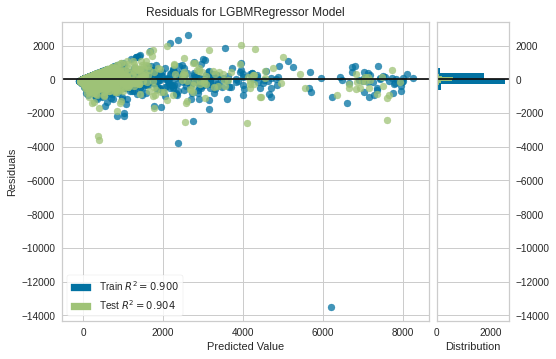

In [48]:
# Residuals Plot 
plot_model(base_model, plot='residuals')

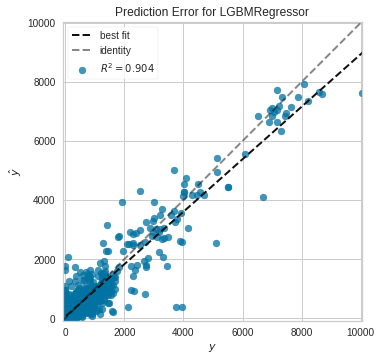

In [49]:
# Prediction Error 
plot_model(base_model, plot='error')

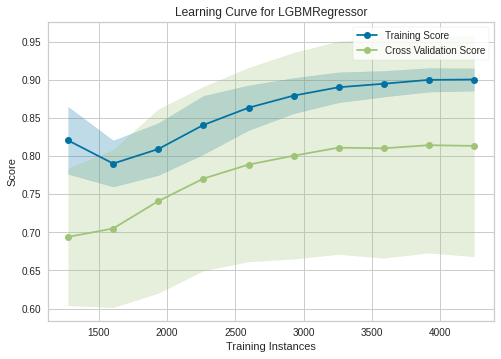

In [50]:
# Learning Curve
plot_model(base_model, plot='learning')

In [51]:
#Predicting for test data
def model_prediction(model, df):
  predictions = predict_model(model, data=df, round=2)
  predictions["Label"][predictions['Label'] < 0] = 0
  total_predicted = predictions["Label"].sum()
  total_actual_value = df["Billed unit"].sum()
  diff = predictions["Label"] - df["Billed unit"]
  total_difference = diff.sum()
  percentage_diff = diff.sum()*100/df["Billed unit"].sum()
  return total_actual_value, total_predicted, total_difference, np.round(percentage_diff,2)

In [52]:
#Predicting for test data
def model_prediction_graphs(model, df, graph_name):
  predictions = predict_model(model, data=df, round=2)
  predictions["Label"][predictions['Label'] < 0] = 0
  total_predicted = predictions["Label"].sum()
  total_actual_value = df["Billed unit"].sum()
  diff = predictions["Label"] - df["Billed unit"]
  total_difference = diff.sum()
  percentage_diff = diff.sum()*100/df["Billed unit"].sum()
  fig=plt.figure(figsize=(10,10), dpi = 80)
  ax = fig.add_subplot(2,2,1)
  sns.distplot(diff,
                  bins=20,
                  kde=True,
                  color="#c6690c")
  plt.title("Distribution of difference between Actual and Predicted Value (Label)")
  plt.ylabel("Count")
  plt.xlabel("Consumption values")
  
  ax = fig.add_subplot(2,2,2)
  sns.distplot(predictions["Billed unit"],
                  bins=20,
                  kde=True,
                  color="#c6690c")
  sns.distplot(predictions["Label"],
                  bins=20,
                  kde=True,
                  color="#664697")
  plt.title("Distribution between Actual and Predicted Value (Label)")
  plt.ylabel("Count")
  plt.xlabel("Consumption values")
  plt.legend(('Actual Value', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=7)
  ax = fig.add_subplot(2,2,3)
  sns.regplot(x="Billed unit", y="Label", data=predictions, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
  plt.title("Linear Relationship between Actual and Predicted Value (Label)")
  plt.ylabel("Predicted Value (Label)")
  plt.xlabel("Actual Value")
  plt.legend(('Best Fit', 'Actual vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=7)
  ax = fig.add_subplot(2,2,4)
  sns.residplot(x="Billed unit", y="Label", data=predictions, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
  plt.title("Residuals for the Predicted values in Final Blend Model")
  plt.ylabel("Residuals")
  plt.xlabel("Predicted Value (Label)")
  plt.legend(('Best Fit', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=7)
  fig.tight_layout()
  plt.savefig(graph_name, dpi = 300, pad_inches = 0.25)
  plt.show()

In [53]:
model_prediction(base_model, test_data_f_imp)

(184899, 182056.04505483597, -2842.9549451640087, -1.54)

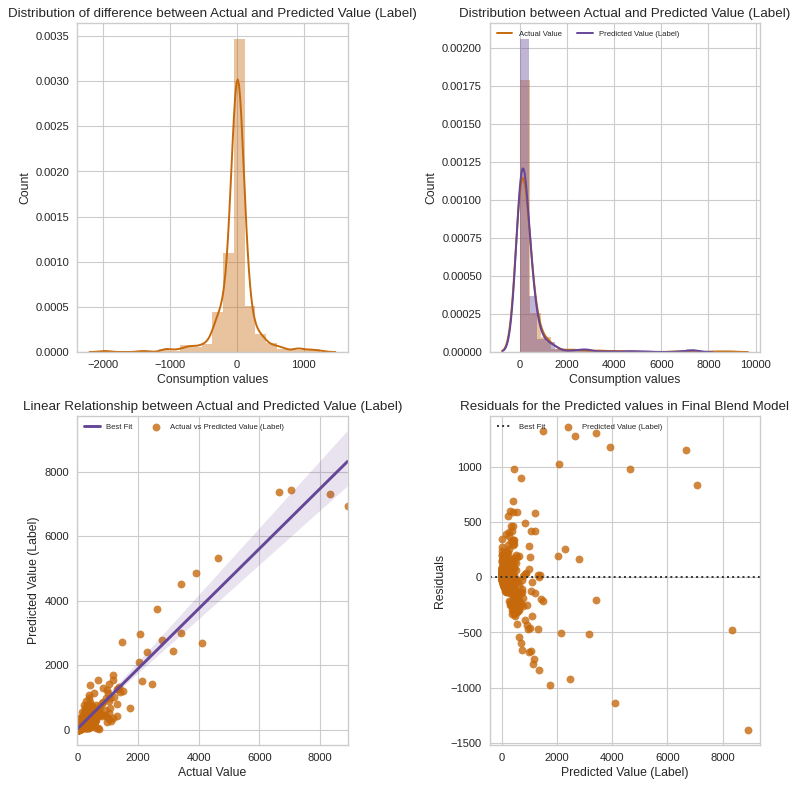

In [54]:
model_prediction_graphs(base_model, test_data_f_imp,"Base_model_performance.png" )

In [55]:
model_prediction(base_model, test_data_f_imp_3)

(83144, 99363.47552285342, 16219.475522853414, 19.51)

In [56]:
model_prediction(base_model, test_data_f_imp_4)

(101755, 82692.56953198258, -19062.430468017417, -18.73)

#**BLENDING AND STACKING**

In [57]:
top5_models = compare_models(n_select = 5, sort = 'R2', fold = 10, verbose = False)
print("\nModels with descending R2 values")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
pull().sort_values(by="R2", ascending = False)


Models with descending R2 values
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,167.0647,181848.3408,386.3238,0.8160,2.0062,1.5443,0.097
br,Bayesian Ridge,181.9562,176938.2000,383.0475,0.8155,2.1848,2.3518,0.018
lr,Linear Regression,181.7330,176945.4805,383.0460,0.8155,2.1805,2.3160,0.017
lar,Least Angle Regression,183.6347,177426.1529,383.7498,0.8151,2.1992,2.4159,0.018
lasso,Lasso Regression,180.8865,177680.4812,384.0172,0.8147,2.1474,2.1246,0.017
ridge,Ridge Regression,184.0412,178031.9656,384.7596,0.8147,2.2026,2.4759,0.015
huber,Huber Regressor,175.9298,178312.0738,384.7625,0.8141,2.0767,1.7207,0.110
par,Passive Aggressive Regressor,176.5013,181948.0090,389.9336,0.8106,2.0353,1.5339,0.094
omp,Orthogonal Matching Pursuit,181.4628,181385.7759,389.6510,0.8099,1.9892,1.5095,0.014
llar,Lasso Least Angle Regression,185.3949,185679.5834,395.1652,0.8062,2.0965,1.8788,0.015


In [58]:
#Tuning each model 
tuned_top5_models = [tune_model(i, n_iter=120, optimize = "R2", fold = 10) for i in top5_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,195.8424,127878.7891,357.6014,0.7580,2.2793,4.8375
1,178.7518,150966.3594,388.5439,0.7613,2.2287,1.8229
2,179.7359,110880.5078,332.9872,0.8523,2.0041,2.6336
3,229.9957,799184.6875,893.9713,0.4232,2.2024,2.4003
4,159.0013,100313.9766,316.7238,0.9068,2.2992,2.9805
5,185.1408,91298.5156,302.1564,0.9438,2.2843,2.0086
6,173.9767,104500.4688,323.2653,0.8724,2.1959,1.9097
7,174.4160,86723.9141,294.4893,0.9079,1.8962,1.2963
8,184.8506,130565.2578,361.3381,0.8913,2.3527,1.8602
9,154.0980,67645.6328,260.0877,0.8377,2.0870,1.4761


###**Blending multiple models**

In [59]:
blender = blend_models(estimator_list=tuned_top5_models[0:], fold = 10, optimize = "R2", choose_better = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,186.9218,119060.2847,345.0511,0.7747,2.2459,4.4937
1,170.8614,146228.6756,382.3986,0.7688,2.1768,1.5765
2,174.8635,109563.4346,331.0037,0.8541,1.9767,2.5136
3,223.5982,802906.4491,896.0505,0.4205,2.1385,2.0240
4,153.9920,99246.5703,315.0342,0.9078,2.2808,2.4431
5,177.6318,87721.1496,296.1776,0.9460,2.2685,1.8252
6,168.7534,104390.6984,323.0955,0.8725,2.1260,1.6486
7,166.9362,81386.5531,285.2833,0.9136,1.8509,1.2312
8,179.4273,128970.0627,359.1240,0.8926,2.3219,1.6701
9,147.2503,63990.3455,252.9631,0.8465,2.0334,1.3164


In [60]:
# We can execute the predict_model() function to use the model to generate the predicted values. 
pred_tuned_blender = predict_model(blender, verbose = 0)
#Saving the prediction result in a dataframe
holdout_score_blender = pull()
display(holdout_score_blender)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,172.2112,97995.2995,313.042,0.9041,2.1457,1.761


In [61]:
# The Blend model seems to perform better in both our train and test so let us finalize it. The finalize_model() function trains the model on the entire dataset. 
finalize_blender = finalize_model(blender)
finalize_blender

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=2,
                                           boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           feature_fraction=1.0,
                                           importance_type='split',
                                           learning_rate=0.01, max_depth=-1,
                                           min_child_samples=16,
                                           min_child_weight=0.001,
                                           min_split_gain=0.3, n_estimators=260,
                                           n_jobs=-1, num_leaves=200,
                                           objective=None, ran...
                             Lars(copy_X=True, eps=0.005, fit_intercept=True,
                                  fit_path=True, 

In [62]:
model_prediction(finalize_blender, test_data_f_imp)

(184899, 180939.1723742218, -3959.82762577821, -2.14)

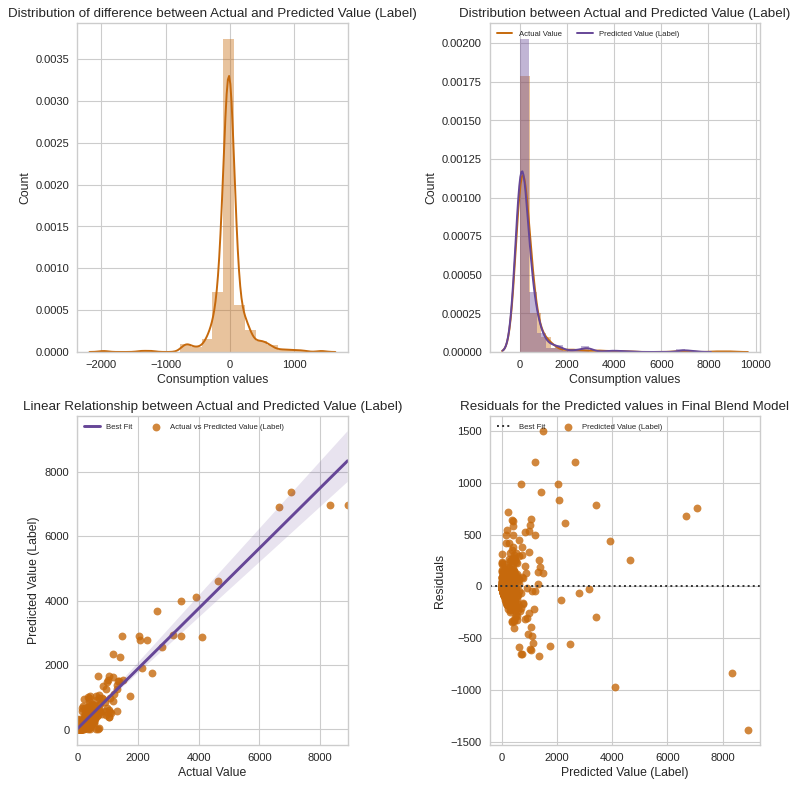

In [63]:
model_prediction_graphs(finalize_blender, test_data_f_imp,"blender_2month.png" )

In [64]:
model_prediction(finalize_blender, test_data_f_imp_3)

(83144, 85100.36896774695, 1956.3689677469547, 2.35)

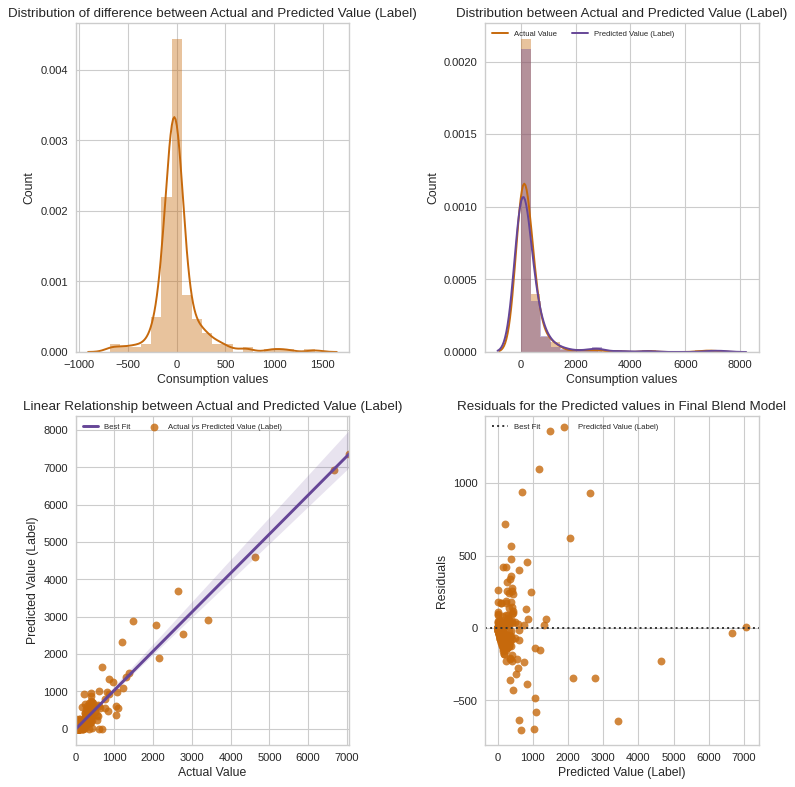

In [65]:
model_prediction_graphs(finalize_blender, test_data_f_imp_3, "blender_Mar.png")

In [66]:
model_prediction(finalize_blender, test_data_f_imp_4)

(101755, 95838.80340647484, -5916.196593525165, -5.81)

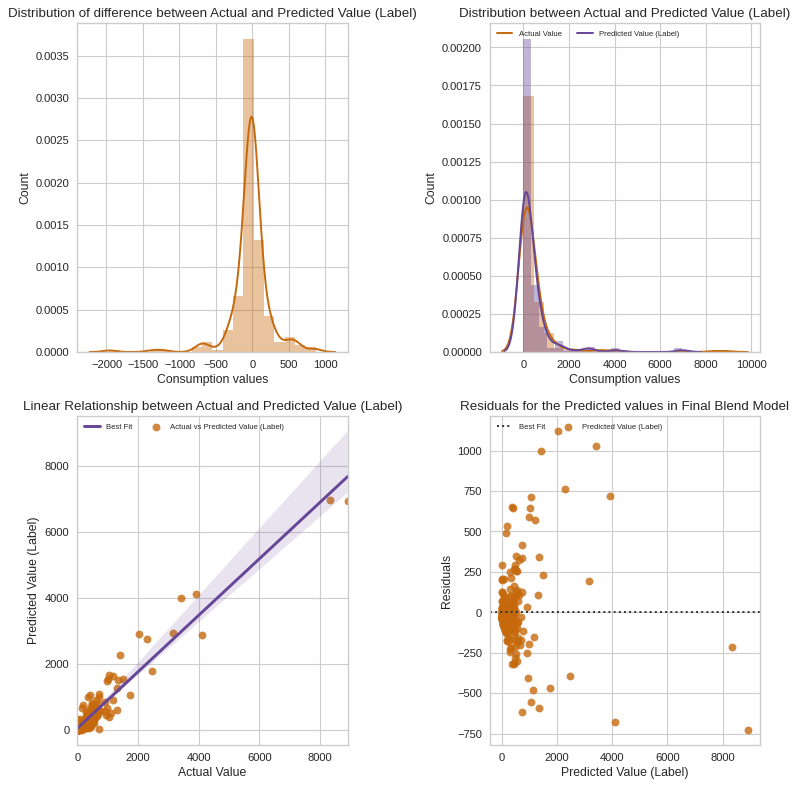

In [67]:
model_prediction_graphs(finalize_blender, test_data_f_imp_4, "blender_Apr.png")

###**Stacking multiple models**

In [68]:
stacker = stack_models(estimator_list=tuned_top5_models[1:], meta_model=tuned_top5_models[0], fold = 10, optimize = "R2", choose_better = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,175.3542,106607.9008,326.5087,0.7982,2.2806,4.7636
1,165.9420,140589.7993,374.9531,0.7777,2.2329,1.8505
2,174.3761,115539.1368,339.9105,0.8461,1.9751,2.6517
3,220.8329,820268.0104,905.6865,0.4080,2.2281,1.9666
4,160.5940,115804.3580,340.3004,0.8924,2.3668,2.1285
5,182.7274,100865.7917,317.5938,0.9379,2.2841,1.6640
6,172.7427,110317.5372,332.1408,0.8653,2.2102,1.7151
7,158.3056,81848.4326,286.0917,0.9131,1.8784,1.5576
8,173.9210,134478.5465,366.7132,0.8880,2.3542,1.5634
9,149.9761,61758.7731,248.5131,0.8518,2.1185,1.6605


In [69]:
# We can execute the predict_model() function to use the model to generate the predicted values. 
pred_tuned_stacker = predict_model(stacker, verbose = 0)
#Saving the prediction result in a dataframe
holdout_score_stacker = pull()
display(holdout_score_stacker)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,168.1064,100555.4621,317.1048,0.9016,2.1686,1.9361


In [70]:
# The Blend model seems to perform better in both our train and test so let us finalize it. The finalize_model() function trains the model on the entire dataset. 
finalize_stacker = finalize_model(stacker)
finalize_stacker

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7F65CC20F7C0,
   shuffle=False),
                  estimators=[('br',
                               BayesianRidge(alpha_1=0.2, alpha_2=0.001,
                                             alpha_init=None,
                                             compute_score=False, copy_X=True,
                                             fit_intercept=True, lambda_1=0.05,
                                             lambda_2=0.2, lambda_init=None,
                                             n_iter=300, normalize=True,
                                             tol=0.001, verbose=False)),
                              ('lr',
                               LinearRegression(co...
                                                feature_fraction=1.0,
                                                importance_type='split',
                                                learning_rate=0.01,
                                

In [71]:
model_prediction(finalize_stacker, test_data_f_imp)

(184899, 187769.1266317563, 2870.1266317563095, 1.55)

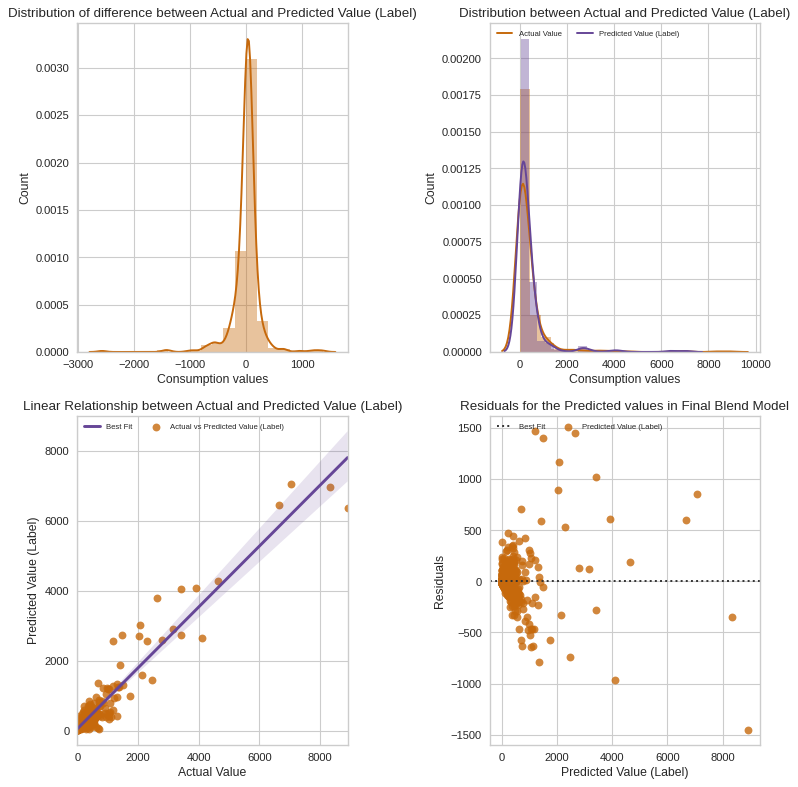

In [72]:
model_prediction_graphs(finalize_stacker, test_data_f_imp,"stacker_2month.png" )

In [73]:
model_prediction(finalize_stacker, test_data_f_imp_3)

(83144, 92442.27943266211, 9298.279432662113, 11.18)

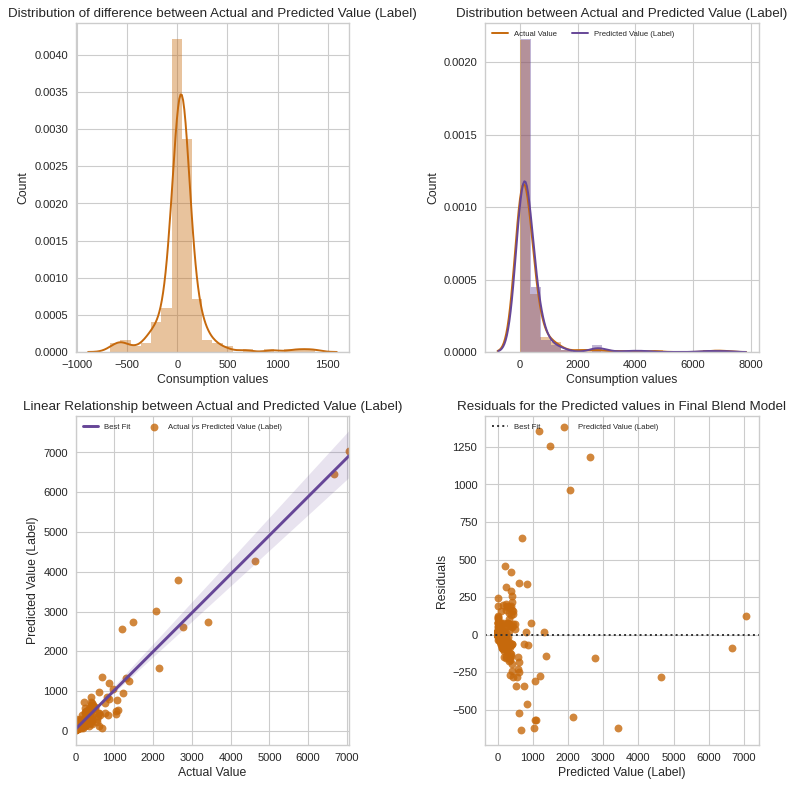

In [74]:
model_prediction_graphs(finalize_stacker, test_data_f_imp_3,"stacker_mar.png" )

In [75]:
model_prediction(finalize_stacker, test_data_f_imp_4)

(101755, 95326.84719909419, -6428.152800905803, -6.32)

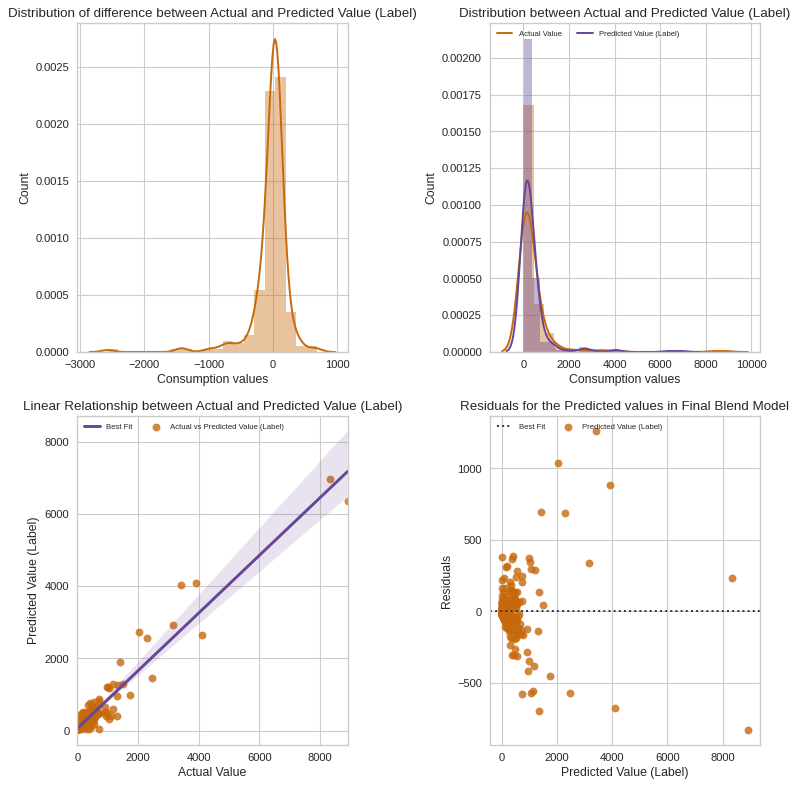

In [76]:
model_prediction_graphs(finalize_stacker, test_data_f_imp_4,"stacker_apr.png" )

In [77]:
!jupyter nbconvert --to html ML_approach_for_consumption_estimation_V1.ipynb

[NbConvertApp] Converting notebook ML_approach_for_consumption_estimation_V1.ipynb to html
[NbConvertApp] Writing 1510957 bytes to ML_approach_for_consumption_estimation_V1.html
